# Resumen Regresión logística

En este notebook haremos un breve resumen de la regresión logística aprovechando otro ejemplo, en este caso, un ejemplo basado en datos bancarios de diferentes clientes. En un entorno real, parte de estos datos estarían protegidos, así que no podrían ser usados. Pero esto es un ejemplo, así que, como no son datos reales, vamos a usarlos.

En este desarrollo haremos un pequeño EDA, veremos cómo realizar una regresión logística mediante sklearn y statsmodels y, finalmente, mediremos nuestro modelo con las métricas que hemos visto, donde aprovecharemos para introducir un concepto nuevo muy utilizado en problemas de clasificación: la curva ROC.

In [493]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [494]:
data = pd.read_csv("data/bank.csv", sep=";")

In [495]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Columnas del dataset

La información que tenemos en el dataset es la siguiente:

1. age (numeric)
2. job : type of job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")
3. marital : marital status (categorical: "divorced", "married", "single", "unknown"; note: "divorced" means divorced or widowed)
4. education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")
5. default: has credit in default? (categorical: "no", "yes", "unknown")
6. housing: has housing loan? (categorical: "no", "yes", "unknown")
7. loan: has personal loan? (categorical: "no", "yes", "unknown")

#### Related with the last contact of the current campaign:
8. contact: contact communication type (categorical: "cellular", "telephone") 
9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. day_of_week: last contact day of the week (categorical: "mon", "tue", "wed", "thu", "fri")
11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### Other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: "failure", "nonexistent", "success")

#### Social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)     
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

#### Varaiable a predecir:
21. y - has the client subscribed a term deposit? (binary: "yes","no")

In [496]:
data.shape

(4119, 21)

In [497]:
data.columns.values

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'], dtype=object)

In [498]:
data['y'].dtype

dtype('O')

In [499]:
data['y'].value_counts()

no     3668
yes     451
Name: y, dtype: int64

Como la variable objetivo es categórica binaria con valores ``string``, la convertiremos a 1/0 para que no nos de posibles errores en el futuro (con statsmodels, por ejemplo)

In [500]:
data["y"] = (data["y"]=="yes").astype(int)

Además, si observamos los valores de la educación:

In [501]:
data["education"].unique()

array(['basic.9y', 'high.school', 'university.degree',
       'professional.course', 'basic.6y', 'basic.4y', 'unknown',
       'illiterate'], dtype=object)

Nos damos cuenta de que quizás haya demasiada variedad, ya que al convertir esta feature con ``get_dummies`` se nos va a crear una columna nueva por cada valor, lo que hará que probablemente caigamos en ``overfitting``. Por eso, mejor será realizar cierta agrupación funcional:

In [502]:
data["education"] = np.where(data["education"]=="basic.4y", "Basic", data["education"])
data["education"] = np.where(data["education"]=="basic.6y", "Basic", data["education"])
data["education"] = np.where(data["education"]=="basic.9y", "Basic", data["education"])

data["education"] = np.where(data["education"]=="high.school", "High School", data["education"])
data["education"] = np.where(data["education"]=="professional.course", "Professional Course", data["education"])
data["education"] = np.where(data["education"]=="university.degree", "University Degree", data["education"])

data["education"] = np.where(data["education"]=="illiterate", "Illiterate", data["education"])
data["education"] = np.where(data["education"]=="unknown", "Unknown", data["education"])

In [503]:
data["education"].unique()

array(['Basic', 'High School', 'University Degree', 'Professional Course',
       'Unknown', 'Illiterate'], dtype=object)

También puede resultar interesante conocer algunos rasgos de las variables en función del target, para adelantar si existe alguna relación que nos pueda ser de utilidad, como podemos ver al hacer la medai y la desviación típica:

In [504]:
data.groupby("y").agg([np.mean, np.std])

age              duration              campaign            \
        mean        std       mean         std      mean       std   
y                                                                    
0  39.895311   9.865468  219.40976  198.256347  2.605780  2.670831   
1  41.889135  13.292977  560.78714  411.537717  1.980044  1.370175   

        pdays              previous           emp.var.rate            \
         mean         std      mean       std         mean       std   
y                                                                      
0  982.763086  125.928646  0.141767  0.429446     0.240185  1.481298   
1  778.722838  413.150869  0.585366  1.003841    -1.177384  1.638610   

  cons.price.idx           cons.conf.idx           euribor3m            \
            mean       std          mean       std      mean       std   
y                                                                        
0      93.599677  0.561238    -40.586723  4.395060  3.802826  1.640054   
1      93.417268  0.689219    -39.786475  5.933069  2.145448  1.769719   

   nr.employed             
          mean        std  
y                          
0  5175.502072  65.906049  
1  5093.118625  90.607987

In [505]:
data.groupby("y").std()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
0,9.865468,198.256347,2.670831,125.928646,0.429446,1.481298,0.561238,4.395060,1.640054,65.906049
1,13.292977,411.537717,1.370175,413.150869,1.003841,1.638610,0.689219,5.933069,1.769719,90.607987


También puede resultar interesante comprobar algunos estadísticos de ciertas categóricas en función de sus valores, como ``Educación``:

In [506]:
data.groupby("education").agg([np.mean, np.std])

age               duration              campaign  \
                          mean        std        mean         std      mean   
education                                                                     
Basic                42.337124  10.816920  253.898457  243.489768  2.429732   
High School          38.097720   9.645409  258.534202  261.551373  2.630836   
Illiterate           42.000000        NaN  146.000000         NaN  4.000000   
Professional Course  40.207477   9.874111  278.816822  300.646382  2.512150   
University Degree    39.017405   9.707178  247.707278  241.178450  2.583070   
Unknown              42.826347  12.233660  267.281437  234.796448  2.538922   

                                    pdays              previous            \
                          std        mean         std      mean       std   
education                                                                   
Basic                2.325481  978.815597  140.248482  0.149472  0.438491   
High School          2.954084  958.022801  197.637103  0.206298  0.542542   
Illiterate                NaN  999.000000         NaN  0.000000       NaN   
Professional Course  2.401494  958.211215  197.151385  0.194393  0.511631   
University Degree    2.581878  947.900316  219.556469  0.207278  0.601985   
Unknown              2.396656  939.700599  235.674130  0.263473  0.777729   

                     ... cons.price.idx           cons.conf.idx            \
                     ...           mean       std          mean       std   
education            ...                                                    
Basic                ...      93.658600  0.568577    -41.120552  4.274714   
High School          ...      93.564314  0.586147    -40.995765  4.610184   
Illiterate           ...      92.201000       NaN    -31.400000       NaN   
Professional Course  ...      93.599630  0.578970    -40.127664  4.702918   
University Degree    ...      93.499109  0.566992    -39.830063  4.706623   
Unknown              ...      93.637455  0.624201    -39.487425  4.602961   

                    euribor3m            nr.employed                    y  \
                         mean       std         mean        std      mean   
education                                                                   
Basic                3.775701  1.649393  5174.133144  65.056376  0.079610   
High School          3.511732  1.764888  5163.212595  73.578428  0.105320   
Illiterate           0.834000       NaN  5076.200000        NaN  0.000000   
Professional Course  3.701426  1.722437  5167.595140  75.929943  0.121495   
University Degree    3.547132  1.763584  5163.023180  78.280306  0.130538   
Unknown              3.410174  1.878283  5151.260479  84.991680  0.155689   

                               
                          std  
education                      
Basic                0.270799  
High School          0.307132  
Illiterate                NaN  
Professional Course  0.327008  
University Degree    0.337028  
Unknown              0.363650  

[6 rows x 22 columns]

Si seguimos profundizando sobre la relación entre la educación y el target, podemos representar gráficas como las siguientes:

*Recuerda que ``pd.crossbar`` servía para hacer una tabla de contingencia*

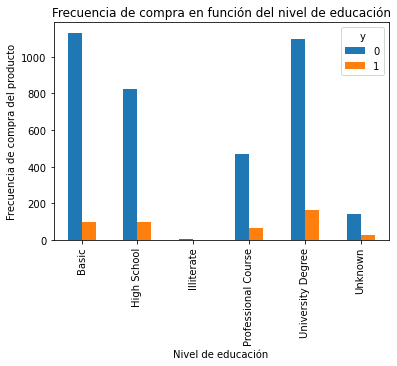

In [507]:
%matplotlib inline
pd.crosstab(data.education, data.y).plot(kind="bar")
plt.title("Frecuencia de compra en función del nivel de educación")
plt.xlabel("Nivel de educación")
plt.ylabel("Frecuencia de compra del producto");

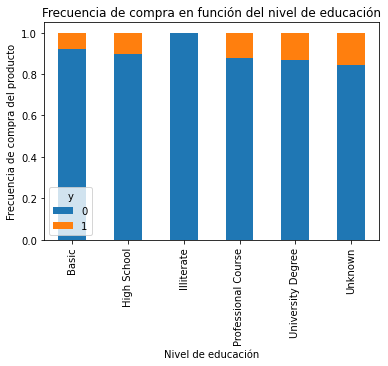

In [508]:
# Nos puede resultar conveniente representarlo en porcentajes, donde las diferencias se ven reducidas:
table = pd.crosstab(data.education, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Frecuencia de compra en función del nivel de educación")
plt.xlabel("Nivel de educación")
plt.ylabel("Frecuencia de compra del producto");

Este estudio resulta ciertamente interesante para conocer cómo se distribuyen los datos respecto a la variable objetivo, lo que nos dará una idea de qué podría ser importante para predecir la variable objetivo. REpitámoslo para las más importantes:

Text(0, 0.5, 'Proporción de clientes')

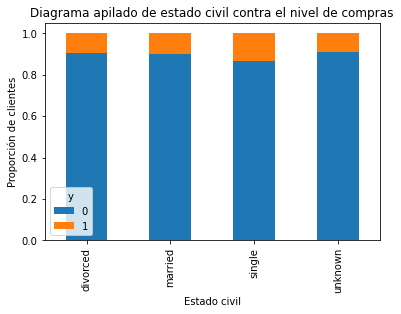

In [509]:
table=pd.crosstab(data.marital, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de estado civil contra el nivel de compras")
plt.xlabel("Estado civil")
plt.ylabel("Proporción de clientes")

Text(0, 0.5, 'Frecuencia de compra del producto')

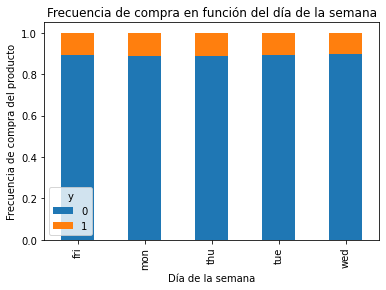

In [510]:
%matplotlib inline
table= pd.crosstab(data.day_of_week, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Frecuencia de compra en función del día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Frecuencia de compra del producto")

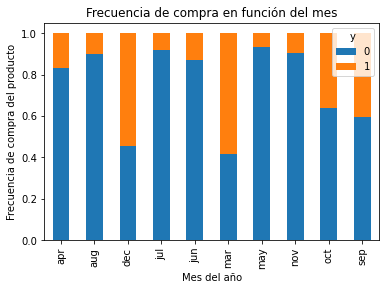

In [511]:
%matplotlib inline
table= pd.crosstab(data.month, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Frecuencia de compra en función del mes")
plt.xlabel("Mes del año")
plt.ylabel("Frecuencia de compra del producto");

En esta variable sí que apreciamos ciertos meses con mayor influencia, como son diciembre y marzo. Además, se aprecia cierta estacionalidad, siendo mayor la facilidad de contratación en invierno. Veamos si podemos sacar más información al respecto:

Text(0, 0.5, 'Frecuencia de compra del producto')

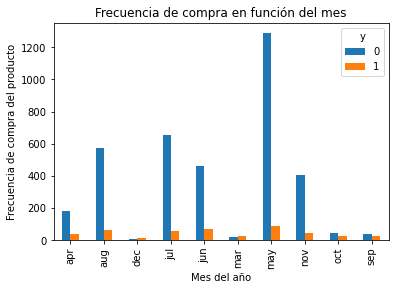

In [512]:
%matplotlib inline
table.plot(kind="bar", stacked=False)
plt.title("Frecuencia de compra en función del mes")
plt.xlabel("Mes del año")
plt.ylabel("Frecuencia de compra del producto")

En cuanto a la edad de los clientes:

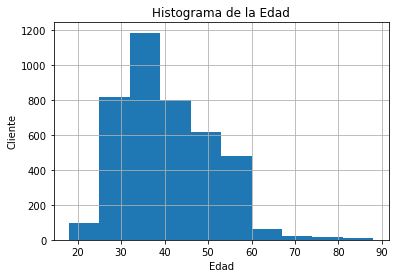

In [513]:
%matplotlib inline
data.age.hist()
plt.title("Histograma de la Edad")
plt.xlabel("Edad")
plt.ylabel("Cliente");

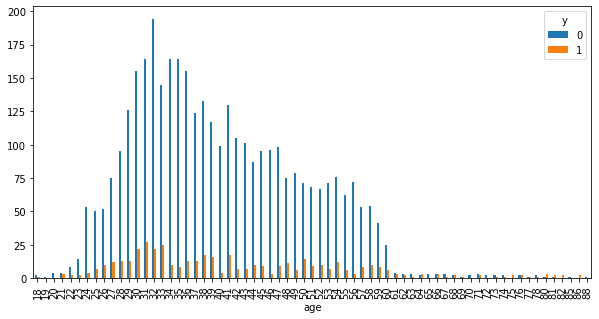

In [514]:
pd.crosstab(data.age, data.y).plot(kind="bar", figsize=(10, 5))

Finalmente, veamos cómo afecta el resultado del ejercicio anterior:

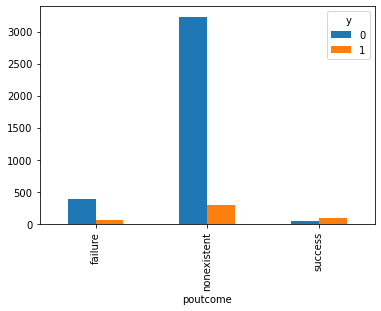

In [515]:
pd.crosstab(data.poutcome, data.y).plot(kind="bar")

In [516]:
data['default'].value_counts()

no         3315
unknown     803
yes           1
Name: default, dtype: int64

### Transformación de datos: conversión de categóricas

Una vez hemos realizado el EDA de los datos de los que disponemos, vamos a transformar los datos para poder utilizarlos en nuestro modelo. En este caso, la mayor parte del tratamiento de datos será convertir las variables categóricas en numéricas:

Como ya hemos convertido la variable ``y`` y hemos agrupado los valores de ``education``, lo siguiente que vamos a hacer es convertir el resto de variables categóricas:

In [517]:
categories = ["job", "marital", "education", "housing", "loan", "contact", "default",
              "month", "day_of_week", "poutcome"]
for category in categories:
    cat_list = "cat" + "_" + category
    cat_dummies = pd.get_dummies(data[category], prefix=category)
    data_new = data.join(cat_dummies)
    data = data_new

In [518]:
data_vars = data.columns.values.tolist()

In [519]:
to_keep = [v for v in data_vars if v not in categories]

In [520]:
bank_data = data[to_keep]
bank_data.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_High School',
       'education_Illiterate', 'education_Professional Course',
       'education_University Degree', 'education_Unknown', 'housing_no',
       'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'default_no',
       'default_unknown', 'default_yes', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

In [521]:
bank_data_vars = bank_data.columns.values.tolist()
y_col = ['y']
X_cols = [v for v in bank_data_vars if v not in Y]

Una vez tenemos las columnas seleccionadas, nos creamos ``X`` e ``y`` para trabajar sobre ellos:

In [522]:
X = bank_data[X_cols]
y = bank_data[y_col]

In [523]:
X

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,0,0,1,0,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,...,0,0,1,0,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0,0,0,0,0,0,1,0,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,0,1,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,53,1,999,0,1.4,93.918,-42.7,4.958,5228.1,...,0,0,0,0,1,0,0,0,1,0
4115,39,219,1,999,0,1.4,93.918,-42.7,4.959,5228.1,...,0,0,1,0,0,0,0,0,1,0
4116,27,64,2,999,1,-1.8,92.893,-46.2,1.354,5099.1,...,0,0,0,1,0,0,0,1,0,0
4117,58,528,1,999,0,1.4,93.444,-36.1,4.966,5228.1,...,0,0,1,0,0,0,0,0,1,0


## Creando el modelo

### Implementación statsmodels (útil para definir el modelo)

Al igual que vimos para la regresión lineal, podemos crear un modelo de regresión logística con ``statsmodels``, que nos permitirá realizar ciertos análisis, como los   pvalores. Para crear el modelo con esta interfaz es más sencillo que lo que veíamos en el caso de la regresión lineal (aunque también se podría hacer algo así en la regresión lineal), ya que no tendremos ni que establecer un parámetro ``formula``:

In [524]:
import statsmodels.api as sm

In [525]:
logit_model = sm.Logit(y, X)

In [526]:
result = logit_model.fit()

         Current function value: 0.194023
         Iterations: 35


C:\Users\TheBridge\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [527]:
result.summary2()

C:\Users\TheBridge\anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\TheBridge\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Logit
=============================================================================================
Model:                       Logit                     Pseudo R-squared:          0.438      
Dependent Variable:          y                         AIC:                       1700.3633  
Date:                        2021-02-02 02:08          BIC:                       2022.8549  
No. Observations:            4119                      Log-Likelihood:            -799.18    
Df Model:                    50                        LL-Null:                   -1422.9    
Df Residuals:                4068                      LLR p-value:               2.6156e-228
Converged:                   0.0000                    Scale:                     1.0000     
No. Iterations:              35.0000                                                         
---------------------------------------------------------------------------------------------
                               Coef.     Std.Err.      z    P>|z|      [0.025       0.975]   
---------------------------------------------------------------------------------------------
age                             0.0078       0.0080  0.9681 0.3330       -0.0080       0.0236
duration                        0.0053       0.0003 20.1804 0.0000        0.0047       0.0058
campaign                       -0.1002       0.0459 -2.1833 0.0290       -0.1902      -0.0103
pdays                          -0.0005       0.0006 -0.7665 0.4434       -0.0018       0.0008
previous                        0.1228       0.1712  0.7174 0.4732       -0.2127       0.4583
emp.var.rate                   -0.8808       0.4646 -1.8959 0.0580       -1.7913       0.0298
cons.price.idx                  1.4307       0.8103  1.7655 0.0775       -0.1576       3.0189
cons.conf.idx                   0.0643       0.0263  2.4439 0.0145        0.0127       0.1159
euribor3m                      -0.1591       0.4166 -0.3819 0.7025       -0.9755       0.6574
nr.employed                     0.0024       0.0099  0.2382 0.8117       -0.0171       0.0218
job_admin.                     -5.0191          nan     nan    nan           nan          nan
job_blue-collar                -5.2308          nan     nan    nan           nan          nan
job_entrepreneur               -5.8064          nan     nan    nan           nan          nan
job_housemaid                  -4.8201          nan     nan    nan           nan          nan
job_management                 -5.3291          nan     nan    nan           nan          nan
job_retired                    -5.2530          nan     nan    nan           nan          nan
job_self-employed              -5.7468          nan     nan    nan           nan          nan
job_services                   -4.8921          nan     nan    nan           nan          nan
job_student                    -5.0979 4178976.9634 -0.0000 1.0000 -8190649.4385 8190639.2427
job_technician                 -4.7993          nan     nan    nan           nan          nan
job_unemployed                 -4.6860          nan     nan    nan           nan          nan
job_unknown                    -5.4897          nan     nan    nan           nan          nan
marital_divorced              -15.7376          nan     nan    nan           nan          nan
marital_married               -15.4615          nan     nan    nan           nan          nan
marital_single                -15.4223          nan     nan    nan           nan          nan
marital_unknown               -15.5073          nan     nan    nan           nan          nan
education_Basic                -7.6115 1999307.6974 -0.0000 1.0000 -3918578.6925 3918563.4695
education_High School          -7.6080 1746387.0878 -0.0000 1.0000 -3422863.4032 3422848.1872
education_Illiterate          -24.3411 1462344.0775 -0.0000 1.0000 -2866166.0660 2866117.3838
education_Professional Course  -7.6416 1912

En base a estos resultados, y dados los errores/warnings que nos dan, podemos iterar hasta obtener las siguientes columnas. No obstante, no te preocupes por esto ahora, ya que en el futuro veremos cómo podemos utilizar algoritmos para que nos digan qué variables seleccionar (de hecho, en este caso nos hemos quedado con una selección hecha con esas técnicas, pero aún es pronto para que os las presente):

In [528]:
X_cols = ["previous", "euribor3m", "job_blue-collar", "job_retired", "month_aug", "month_dec", 
        "month_jul", "month_jun", "month_mar", "month_nov", "day_of_week_wed", "poutcome_nonexistent"]

X = X[X_cols]

logit_model = sm.Logit(y, X)
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.291770
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             Pseudo R-squared:  0.155     
Dependent Variable:   y                 AIC:               2427.6025 
Date:                 2021-02-02 02:09  BIC:               2503.4828 
No. Observations:     4119              Log-Likelihood:    -1201.8   
Df Model:             11                LL-Null:           -1422.9   
Df Residuals:         4107              LLR p-value:       6.4492e-88
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
previous             -0.1229   0.0700  -1.7545 0.0793 -0.2601  0.0144
euribor3m            -0.6049   0.0383 -15.7882 0.0000 -0.6800 -0.5298
job_blue-collar      -0.5032   0.1519  -3.3136 0.0009 -0.8009 -0.2056
job_retired           0.2235   0.2191   1.0205 0.3075 -0.2058  0.6529
month_aug             0.6048   0.1759   3.4374 0.0006  0.2600  0.9497
month_dec             1.1358   0.4493   2.5281 0.0115  0.2552  2.0163
month_jul             1.0327   0.1910   5.4071 0.0000  0.6584  1.4070
month_jun             1.0775   0.1752   6.1493 0.0000  0.7341  1.4210
month_mar             1.6448   0.3139   5.2407 0.0000  1.0297  2.2600
month_nov             0.3828   0.1950   1.9634 0.0496  0.0007  0.7649
day_of_week_wed      -0.0649   0.1391  -0.4665 0.6409 -0.3375  0.2077
poutcome_nonexistent -0.7753   0.1221  -6.3492 0.0000 -1.0147 -0.5360
=====================================================================

"""

#### ¿Qué nos dice esta tabla?

Resumen:
- Model: modelo entrenado
- Date: fecha del modelo
- No. Observations: Número de observaciones
- Df Model: Número de grados de libertad del modelo (n_varaibles - 1)
- Df Residuals: Número de residuos del modelo (No. Observaciones - Df Model)
- No. Iterations: Número de iteraciones hasta converger (o no, en cuyo caso será el límite, modificable en el método ``fit`` mediante el parámetro ``maxiters``). Está basado en el método de Newton-Raphson
- Pseudo R-squared: métrica R cuadrado para este modelo (no es muy bueno)
- AIC: criterio de información de Akaike, utilizado para comparar las eficiencias entre modelos
- BIC: criterio de información Bayesiano, utilizado para comparar las eficiencias entre modelos
- Log-Likelihood: Logaritmo de verosimilitud (relacionado con cómo obtiene los coeficientes)

Pero lo realmente interesante, lo que debemos hacer al ver esta tabla, es actuar en función de los pvalores, eliminando aquellas varaibles que apenas afectarán a la varaible final (aquellas con pvalores altos, superiores a cierto umbral)

#### Implementación scikit-learn (útil para la creación en sí del modelo)

Una vez estudiado el modelo mediante statsmodels (paso completamente opcional), podemos pensar en utilizar la implementaión de scikit-learn, que es igual que lo que hemos visto para la regresión lineal:

In [529]:
from sklearn import linear_model

In [530]:
log_model = linear_model.LogisticRegression().fit(X, y)
log_model.score(X, y)

C:\Users\TheBridge\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8958485069191552

¿Es bueno el modelo? Pues a priori sí pero, como hemos visto anteriormente, todo dependerá de la distribución de los datos:

In [531]:
y['y'].value_counts()

0    3668
1     451
Name: y, dtype: int64

In [532]:
# Como están muy desbalanceados, sacaremos cuál es la probabilidad de acierto si digo que saco 0 siempre:
y[y['y']==0].count()/len(y)

y    0.890507
dtype: float64

Finalmente, podemos sacar los coeficientes del siguiente modo, en base a las variables, para ver si afectan positiva o negativamente (ya que el valor estará condicionado a la escala):

In [533]:
pd.DataFrame(zip(X.columns, log_model.coef_.T))

,0,1
0,previous,[0.5362541179381884]
1,euribor3m,[-0.5443670397998119]
2,job_blue-collar,[-0.353313874349369]
3,job_retired,[0.3616515908105932]
4,month_aug,[0.6292588895080209]
5,month_dec,[1.1943974572125013]
6,month_jul,[0.9630554140676566]
7,month_jun,[1.0566897056474196]
8,month_mar,[1.6386680234602646]
9,month_nov,[0.45770841910639576]


### EJERCICIO

Usa las otras métricas que hemos visto para cuantificar el desempeño de este modelo en entrenamiento:

## Validación

Como hemos visto, un modelo hay que validarlo bien. Y para ello tenemos que dar diferentes pasos. En primero lugar, validaremos el modelo realizando una separación train/test. Y, en segundo lugar, probaremos a realizar la validación cruzada:

In [534]:
from sklearn.model_selection import train_test_split

In [535]:
X_train, X_test, y_train, y_test = train_test_split(X, y['y'], test_size = 0.3, random_state=0)

In [536]:
lm = linear_model.LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression()

Lo que hace el algoritmo es básicamente, sacar probabilidades de que sea una clase u otra, y las compara con un umbral. Por defecto, este umbral es de 0.5:

In [537]:
from IPython.display import display, Math, Latex

In [538]:
display(Math(r'Y_p=\begin{cases}0& si\ p\leq0.5\\1&si\ p >0.5\end{cases}'))

<IPython.core.display.Math object>

In [539]:
probs = lm.predict_proba(X_test)

In [540]:
probs

array([[0.95409621, 0.04590379],
       [0.83896646, 0.16103354],
       [0.93216535, 0.06783465],
       ...,
       [0.65098445, 0.34901555],
       [0.97381005, 0.02618995],
       [0.57635748, 0.42364252]])

In [541]:
prediction = lm.predict(X_test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

Sin embargo, este umbral puede ser cambiado. Esto es especialmente útil en casos donde no nos resulte igual de malo perder ciertos registros que el que se nos cuelen malos.; es decir, que no nos resulta lo mismo un error de Tipo I que un error de Tipo II, como el ejemplo de los vídeos para niños:

In [542]:
display(Math(r'\varepsilon\in (0,1), Y_p=\begin{cases}0& si\ p\leq \varepsilon\\1&si\ p >\varepsilon\end{cases}'))

<IPython.core.display.Math object>

Probamos, por ejemplo, a cambiar el umbral a 0.1, de modo que consideraré como 1 todo lo que supere ese umbral tan bajo. En este caso, estoy priorizando capturar más 1s a cambio de que se me cuelen 0s:


In [543]:
prob = probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.1
prob_df["prediction_0_1"] = np.where(prob_df[0]>threshold, 1, 0)
prob_df.head()

,0,prediction_0_1
0,0.045904,0
1,0.161034,1
2,0.067835,0
3,0.062222,0
4,0.042308,0


In [544]:
pd.crosstab(prob_df.prediction_0_1, columns="count")

col_0,count
prediction_0_1,
0,846
1,390


In [545]:
390/len(prob_df)*100

31.55339805825243

In [546]:
threshold = 0.15
prob_df["prediction_0_15"] = np.where(prob_df[0]>threshold, 1, 0)
pd.crosstab(prob_df.prediction_0_15, columns="count")

col_0,count
prediction_0_15,
0,915
1,321


In [547]:
331/len(prob_df)*100

26.779935275080906

In [548]:
threshold = 0.05
prob_df["prediction_0_05"] = np.where(prob_df[0]>threshold, 1, 0)
pd.crosstab(prob_df.prediction_0_05, columns="count")

col_0,count
prediction_0_05,
0,504
1,732


In [549]:
732/len(prob_df)*100

59.22330097087378

In [550]:
from sklearn import metrics

In [551]:
print(f"Umbral = 0.5: {metrics.accuracy_score(y_test, prediction)}")
print(f"Umbral = 0.05: {metrics.accuracy_score(y_test, prob_df['prediction_0_05'])}")
print(f"Umbral = 0.10: {metrics.accuracy_score(y_test, prob_df['prediction_0_1'])}")
print(f"Umbral = 0.15: {metrics.accuracy_score(y_test, prob_df['prediction_0_15'])}")

Umbral = 0.5: 0.901294498381877
Umbral = 0.05: 0.47572815533980584
Umbral = 0.10: 0.7184466019417476
Umbral = 0.15: 0.7645631067961165


### Validación cruzada

Una vez visto el tema de los umbrales, podemos pasar a la validación cruzada, la cual resumimos muy rápidamente:

In [552]:
from sklearn.model_selection import cross_val_score

In [553]:
scores = cross_val_score(linear_model.LogisticRegression(), X, y['y'], scoring="accuracy", cv=10)

In [554]:
scores

array([0.90533981, 0.88834951, 0.90533981, 0.89563107, 0.90048544,
       0.8907767 , 0.88349515, 0.89320388, 0.89320388, 0.88807786])

In [555]:
scores.mean()

0.8943903101599225

Observamos que la media del resultado varía muy poco, auqnue se sitúa en torno al valor que obteníamos al predecir todo 0

## Matrices de Confusión y curvas ROC

Finalmente, llegamos a la parte de las métricas, donde veremos un concepto nuevo: la curva ROC.

En primer lugar, comenzaremos definiendo la matriz de confusión:

In [556]:
X_train, X_test, y_train, y_test = train_test_split(X, y['y'], test_size=0.3, random_state=0)

In [557]:
lm = linear_model.LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression()

In [558]:
probs = lm.predict_proba(X_test)

In [559]:
prob=probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.1
prob_df["prediction"] = np.where(prob_df[0]>=threshold, 1, 0)
prob_df["actual"] = list(y_test)
prob_df.head()

,0,prediction,actual
0,0.045904,0,0
1,0.161034,1,0
2,0.067835,0,0
3,0.062222,0,0
4,0.042308,0,0


In [560]:
confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)

In [561]:
# Sacamos nuestros indicadores básicos de la matriz de confusión, con los que sacaremos el resto de métricas:
TN=confusion_matrix[0][0]
TP=confusion_matrix[1][1]
FN=confusion_matrix[0][1]
FP=confusion_matrix[1][0]

En base a estos indicadores, sacaremos 2 parámetros muy interesantes: el TPR (True Positive Rate) y el FPR (False Negative Rate), que nos ayudarán a representar la curva ROC, que es una curva que nos irá describiendo el funcionamiento del algoitmo en base a los umbrales que estábamos definiendo antes:

In [562]:
# True Positive Rate o Sensibilidad:
TPR = TP/(TP+FN)
TPR

0.21025641025641026

In [563]:
# False Negative Rate o 1-Especificidad:
FPR = FP/(FP+TN)
FPR

0.04728132387706856

Es en este momento cuando entran en juego los umbrales que veíamos antes. ¿Para qué sirven? Pues nos permiten conocer cómo se desenvuelve nuestro algoritmo según nos vamos moviendo por el eje X, añadiendo más sujetos a nuestro rango de acción.

En muchos casos, como es este caso, lo que estamos representando es el éxito frente a cierta acción comercial, lo que hace que sea extremadamente relevante seleccionar un subconjunto de clientes, ya que no podremos atacar a todos de golpe. Si nuestro algoritmo crece muy rápido al principio y se establece al final, significará que los primeros clientes que coja (los más propensos, ya que estaríamos ordenando por probabilidades) tendrán un éxito mayor que el algoritmo completo. Y eso es lo que nos interesará, que de los clientes que tomemos obtengamos el mejor resultado posible.

Sin embargo, si tenemos un algoritmo que crece cercano a la línea diagonal, indicará que no nos permite distinguir lo buenos de los malos demasiado bien.

Esta línea se llama curva ROC, y refleja esta evolución. Para medir los algoritmos de clasificación, como una curva en sí no sería un número con el que comparar, utilizamos el denominado AUC (Area Under the Curve), que indica el área bajo la curva ROC. De este modo, cuanto antes crezca la curva ROC, es decir, cuantos más clientes consigamos alcanzar al principio, mayor área tendremos.

Veamos un ejemplo de cómo podemos dibujarla:

In [600]:
thresholds = [0.04, 0.05, 0.07, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.3, 0.4, 0.5]
TPRs = [1]
FPRs = [1]

for t in thresholds:
    prob_df["prediction"] = np.where(prob_df[0]>=t, 1, 0)
    prob_df["actual"] = list(y_test)
    prob_df.head()

    confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)
    TN=confusion_matrix[0][0]
    TP=confusion_matrix[1][1]
    FP=confusion_matrix[0][1]
    FN=confusion_matrix[1][0]
    
    TPR = TP/(TP+FN)
    TPRs.append(TPR)
    FPR = FP/(FP + TN)
    FPRs.append(FPR)

TPRs.append(0)
FPRs.append(0)

In [601]:
import matplotlib.pyplot as plt

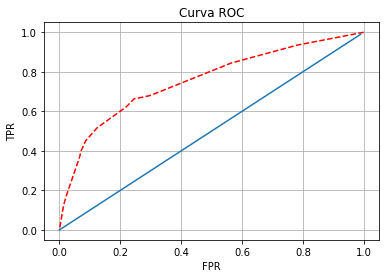

In [603]:
%matplotlib inline
plt.plot(FPRs, TPRs, linestyle="--", color="r")
x_points=[i*0.01 for i in range(100)]
y_points=[i*0.01 for i in range(100)]
plt.plot(x_points, y_points)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.grid();

### EJERCICIO

¿Qué pasa si quiero aumentar la precisión de la curva y pongo un vector desde el 0 al 1 con 200 puntos equiespaciados? Si te falla, intenta solucionarlo y representa la curva ROC para ese vector de umbrales:

In [607]:
thresholds = list(np.linspace(0, 1, 200))
FPRs = [1]
TPRs = [1]

# Si queremos mayor número de umbrales, puede que nos topemos con algún caso donde con cierto umbral solo predecimos una cosa. Si nos basamos
#en lo anterior, podemos llegar a fallar, así que utilizaremos una simple función para evitar esto:
def no_falles(cm, ind0, ind1):
    try:
        return cm[ind0][ind1]
    except:
        return 0

for t in thresholds:
    prob_df["prediction"] = np.where(prob_df[0]>=t, 1, 0)
    prob_df["actual"] = list(y_test)
    prob_df.head()

    confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)
    TN = no_falles(confusion_matrix, 0, 0)
    TP = no_falles(confusion_matrix, 1, 1)
    FP = no_falles(confusion_matrix, 0, 1)
    FN = no_falles(confusion_matrix, 1, 0)
    
    TPR = TP/(TP+FN)
    TPRs.append(TPR)
    FPR = FP/(FP + TN)
    FPRs.append(FPR)

TPRs.append(0)
FPRs.append(0)

In [608]:
import matplotlib.pyplot as plt

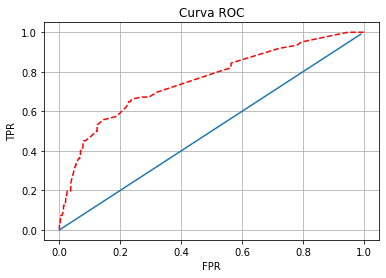

In [610]:
%matplotlib inline
plt.plot(FPRs, TPRs, linestyle="--", color="r")
x_points=[i*0.01 for i in range(100)]
y_points=[i*0.01 for i in range(100)]
plt.plot(x_points, y_points)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.grid();

In [1]:
# Podemos calcularlo con una función de sklearn

preds = prob_df["prediction"]
fpr, tpr, thresholds = metrics.roc_curve(list(prob_df['actual']), list(prob_df[0]))

NameError: name 'prob_df' is not defined

In [612]:
metrics.auc(fpr, tpr)

0.7579171204049798

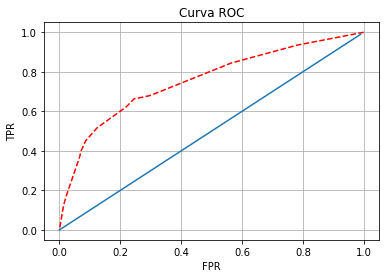

In [613]:
%matplotlib inline
plt.plot(especifities_1, sensitivities, linestyle="--", color="r")
plt.plot(x_points, y_points)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.grid();